In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#export
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import manifold,neighbors
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree, fcluster,distance  
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import Phylo
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import gc
import random
import multiprocessing as mp
from gensim.models import KeyedVectors

### Sample Ksent 

In [3]:
#export
FASTA = "/home/serge/data/genomes/ncbi-genomes-2019-04-07/"
labels = []
ff = glob(f"{FASTA}*.gz")

import gzip
from functools import partial
import re

def get_spicies(d):
    sp = d.split()[2]
    if sp == "sp.": sp = "".join(d.split()[2:4])
    return sp

def clean(d):  return re.sub(r'[{}\[\]\"\']',"",d)

def get_description(d, c=True):return clean(d) if c else d

def get_genus(d):
    return d.split()[1]

def get_family(d):
    return " ".join([get_genus(d),get_spicies(d)])

def keep(k, d):
    return k in d if type(k) == str else  any([x in d for x in k])


def read_fastas(files, label, k=" ", seq=True, d="plasmid", compressed=True):
    if compressed:
        _open = partial(gzip.open, mode="rt")
    else:
        _open = open
    for file in tqdm(files):
        with _open(file) as handle:
            for record in SeqIO.parse(handle, "fasta"):
                 if  keep(k,record.description) and not keep(d, record.description):
                    yield (str(record.seq),label(record.description),len(record.seq)) if seq else (label(record.description),len(record.seq))

In [ ]:
inventory = pd.DataFrame(read_fastas(ff,label=get_description, seq=False), columns=["description","seq_len"])

In [191]:
inventory["genus"] = [get_genus(x) for x in inventory.description.values]
inventory["spicies"]=[get_spicies(x) for x in inventory.description.values]

In [208]:
b= inventory.groupby(["genus", "spicies"]).agg({"description": "count" })

In [210]:
b.loc["Bacillus"].sort_values("description", ascending = False)

,description
spicies,
subtilis,107
velezensis,72
anthracis,51
cereus,49
thuringiensis,45
amyloliquefaciens,36
licheniformis,25
cytotoxicus,11
pumilus,9


In [211]:
b.loc["Pseudomonas"].sort_values("description", ascending = False)

,description
spicies,
aeruginosa,182
chlororaphis,43
syringae,29
putida,29
fluorescens,22
stutzeri,17
protegens,7
synxantha,6
mendocina,6


In [6]:
df = pd.DataFrame(read_fastas(ff,get_family, ["Bacillus","Pseudomonas"]), columns=["seq", "sp","len"])

100%|██████████| 13050/13050 [15:27<00:00, 15.79it/s]


In [7]:
df.shape

(1019, 3)

In [8]:
df.sp.value_counts()

Pseudomonas aeruginosa        182
Bacillus subtilis             107
Bacillus velezensis            72
Bacillus anthracis             51
Bacillus cereus                49
Bacillus thuringiensis         44
Pseudomonas chlororaphis       43
Bacillus amyloliquefaciens     36
Pseudomonas putida             29
Pseudomonas syringae           28
Bacillus licheniformis         25
Pseudomonas fluorescens        22
Pseudomonas stutzeri           17
Bacillus cytotoxicus           11
Bacillus megaterium             9
Bacillus pumilus                9
Bacillus coagulans              8
Pseudomonas protegens           7
Bacillus paralicheniformis      7
Pseudomonas synxantha           6
Pseudomonas mendocina           6
Bacillus safensis               5
Pseudomonas monteilii           5
Pseudomonas orientalis          5
Bacillus cellulasensis          4
Bacillus altitudinis            4
Pseudomonas brassicacearum      4
Bacillus glycinifermentans      3
Pseudomonas koreensis           3
Pseudomonas en

In [13]:
def keep_cnt(series, k):
    v = series.values
    lb = np.asarray([c >= k[0] for c in v])
    ub = np.asarray([c <= k[1] for c in v])
    mask = np.logical_and(ub, lb)
    return series[mask] 


In [19]:
families = keep_cnt(df.sp.value_counts(),(10,51))

In [23]:
selected = df.loc[[x in families for x in df.sp.values],:]  

In [24]:
selected.sp.value_counts()

Bacillus anthracis            51
Bacillus cereus               49
Bacillus thuringiensis        44
Pseudomonas chlororaphis      43
Bacillus amyloliquefaciens    36
Pseudomonas putida            29
Pseudomonas syringae          28
Bacillus licheniformis        25
Pseudomonas fluorescens       22
Pseudomonas stutzeri          17
Bacillus cytotoxicus          11
Name: sp, dtype: int64

In [25]:
selected.to_pickle("../data/ncbi-genomes-2019-04-07_families_with_10_to_50_sequences.pkl")

### Create Ksent data frame

In [26]:
word_vectors = KeyedVectors.load_word2vec_format('/home/serge/data/genomes/embeddings/dna2vec-20190612-1611-k10to10-100d-10c-4870Mbp-sliding-kPR.w2v')

/home/serge/anaconda3/envs/bio/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [27]:
selected =  pd.read_pickle("../data/ncbi-genomes-2019-04-07_families_with_10_to_50_sequences.pkl")

In [28]:
#export
import random
def check_alphabet(x):
    return set(x) == {'A', 'C', 'G', 'T'} 

def vectorise(tokens, label, wv):
    return (label, np.mean(wv[tokens], axis=0).astype(np.float64) )

def tokenise(seq, start,size,step):
    """step - length of kmer, size - length of ksent"""
    seq = "".join(seq[start:start+size])
    t = ["".join(seq[i:i+step]) for i in range(len(seq)-step)]
    tokens = list(filter(check_alphabet, t))
    return tokens

def ksent(df, wv, ksent_len=16000, n=100, randomise = True):
    """Create Ksent vectors"""
    ksent = []
    def _token():
        """token generator"""
        for index, row in df.iterrows():
            s, sp, l = row
            samples = random.sample(range(0,l-ksent_len), n) if randomise else list(range(0,ksent_len*n, ksent_len))
            if not randomise and l < ksent_len * n: continue
            for hop in samples:    
                yield (tokenise(s, hop, ksent_len, 10), sp)
                
    ksent = [vectorise(x, label, wv) for x,label in tqdm(_token(), total=df.shape[0]*n)]
    return pd.DataFrame(ksent, columns=[ "spicies","ksent"]).set_index("spicies")


In [29]:
%time vectors = ksent(selected,word_vectors, n=1)

100%|██████████| 355/355 [00:28<00:00, 13.18it/s]

CPU times: user 27.9 s, sys: 441 ms, total: 28.4 s
Wall time: 28.3 s


In [12]:
vectors.to_pickle("../data/ksent_vectors_baccilium_1000_samples_per_fasta_run2.pkl")

### Reduce dimensions and plot

In [39]:
def plot_3d(d, title, table = False):
    fig = plt.figure(figsize=(13,13))
    ax = fig.add_subplot(111,projection="3d")
    for i , sp in enumerate(d.index.value_counts().index.values):
        cells=d.loc[d.index.values == sp,:].values
        ax.scatter(cells[:,0],cells[:,1],cells[:,2], marker="o", s=50, alpha=0.5,  label = sp)
    ax.set_xlabel('d1')
    ax.set_ylabel('d2')
    ax.set_zlabel('d3')
    ax.set_title(title)
    if table: 
        pd.plotting.table(ax,d.groupby(["spicies"]).agg({0:[min,max,np.mean,np.std],1:[min,max,np.mean,np.std],2:[min,max,np.mean,np.std]}))
    plt.legend()
    plt.show()

#### Embedding reduction

In [32]:

import sys, os
sys.path.append(".")
from KlsAutoencoder import *
e = Encoder("../data/models/encoder-3d",[100,50,3]);e

In [42]:
v = np.vstack(vectors.ksent)

In [43]:
%time d = pd.DataFrame(e.transform(v), index = vectors.index)

CPU times: user 9.67 ms, sys: 0 ns, total: 9.67 ms
Wall time: 8.96 ms


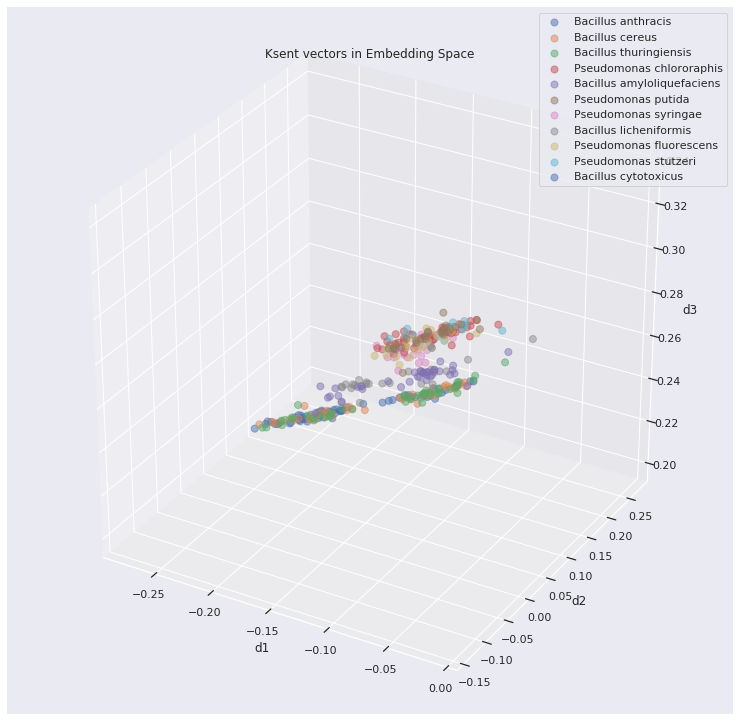

In [44]:
plot_3d(d, "Ksent vectors in Embedding Space")

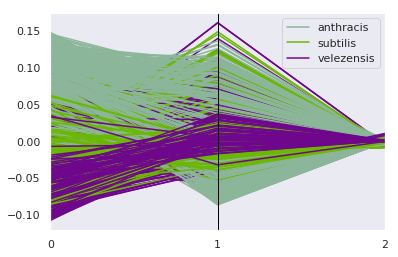

In [107]:
_ = pd.plotting.parallel_coordinates(d.reset_index(),"spicies")

#### TSNE Reduction

In [108]:
perplexity = 50
%time tsne = TSNE(n_components=3, perplexity=perplexity).fit_transform(d.values)
d = pd.DataFrame(tsne, index = vectors.index)

CPU times: user 5min 49s, sys: 72.2 ms, total: 5min 49s
Wall time: 5min 49s


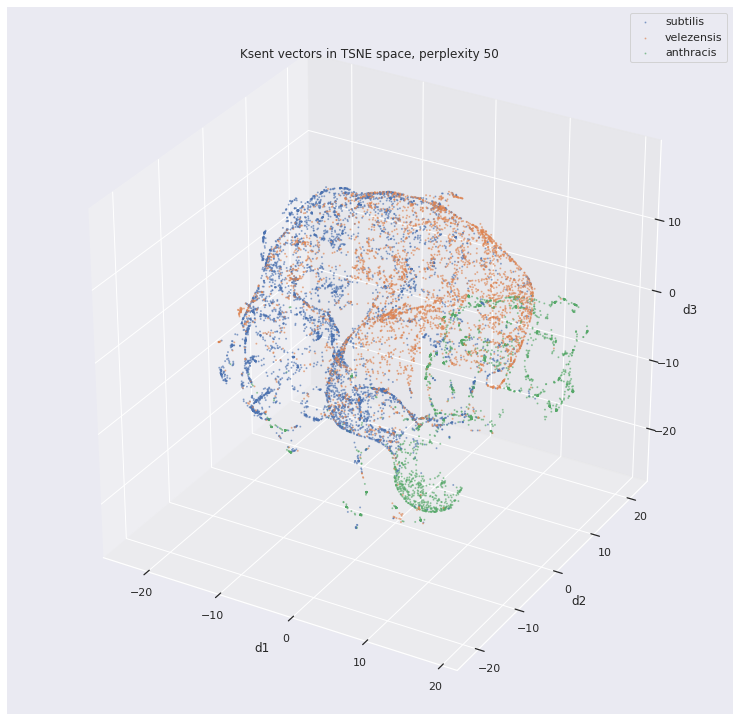

In [109]:
plot_3d(d,f"Ksent vectors in TSNE space, perplexity {perplexity}" )

#### PCA Reduction

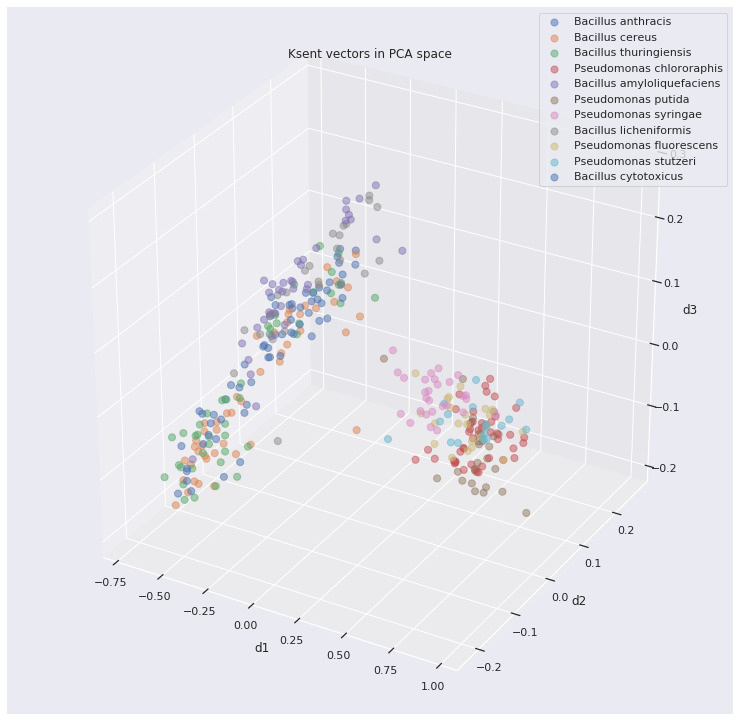

In [45]:
d = PCA(n_components=3).fit_transform(v)
d = pd.DataFrame(d,index = vectors.index)

plot_3d(d, "Ksent vectors in PCA space")
